## Toyota Car Price Prediction Using Regression Models

### Importing Libraries

In [158]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Loading and Discovering the Data

In this project, we will be using this [dataset](https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes/data). It has multiple .csv files inside and one of them is `toyota.csv`

In [114]:
df = pd.read_csv("data/toyota.csv")
df.head(5)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [115]:
df.dtypes

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object

In [116]:
df.shape

(6738, 9)

In [117]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


### Duplicated or Missing Values

In [118]:
print(df.duplicated().sum())

39


As seen, the dataframe has 39 duplicated rows. We have to drop these.

In [119]:
df = df.drop_duplicates()

In [120]:
df.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

Fortunately, it doesn't have any missing/nan values.

In [121]:
df.shape

(6699, 9)

### Dropping Selected Column(s)

Our project's aim is to create a regression model, so we don't need values of type `object`.

In [122]:
df = df.drop(["model", "transmission", "fuelType"], axis=1)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6699 entries, 0 to 6737
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        6699 non-null   int64  
 1   price       6699 non-null   int64  
 2   mileage     6699 non-null   int64  
 3   tax         6699 non-null   int64  
 4   mpg         6699 non-null   float64
 5   engineSize  6699 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 366.4 KB


### Plots

It is clear that the values in the `price` column contain outliers.

<Axes: xlabel='price'>

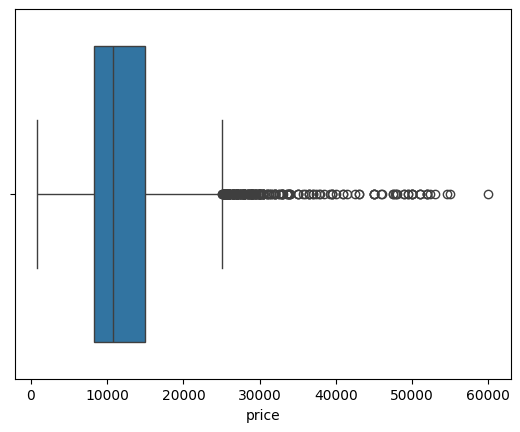

In [124]:
sns.boxplot(x=df["price"])

The figure below is referred to as "positively skewed". However, you can still observe some higher prices.

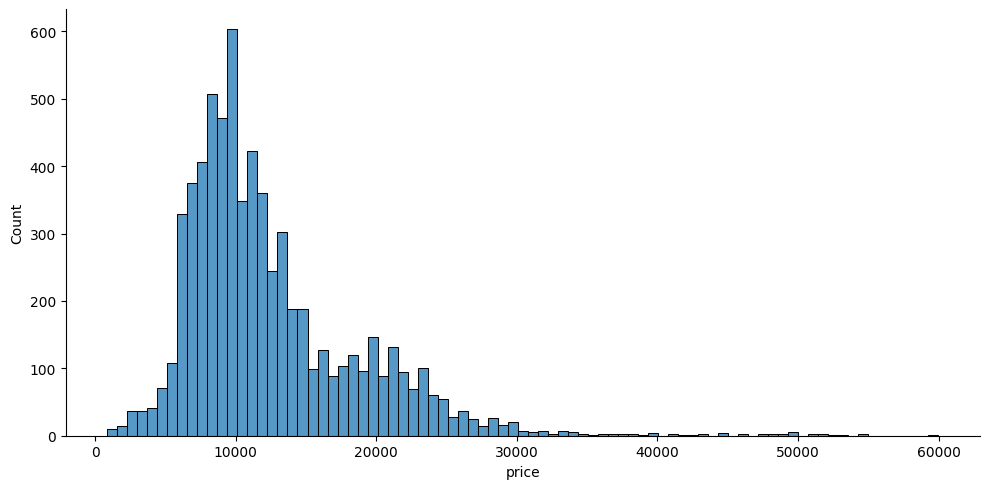

In [125]:
sns.displot(df, x="price", height=5, aspect=2)

<Axes: xlabel='year', ylabel='count'>

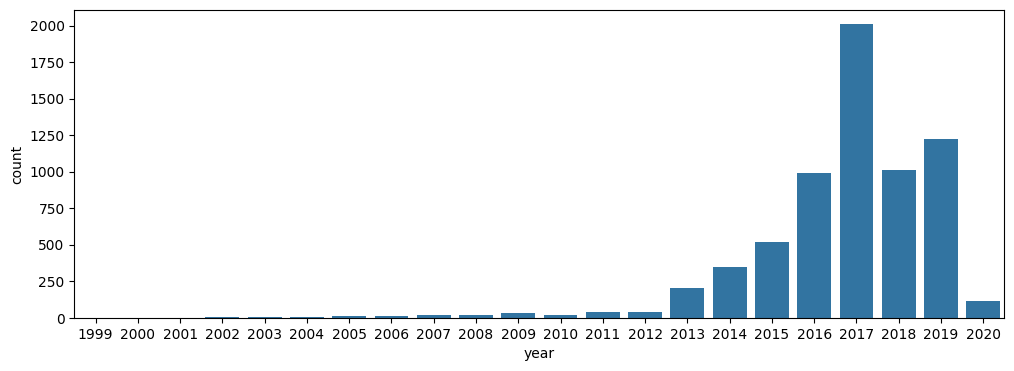

In [157]:
plt.figure(figsize=(12,4))
sns.countplot(df, x="year")

### Correlation

In this step, we will examine the correlation between the columns.

In [127]:
df.corr(numeric_only=True)

,year,price,mileage,tax,mpg,engineSize
year,1.000000,0.422813,-0.726943,0.282585,-0.019372,-0.041643
price,0.422813,1.000000,-0.300598,0.215401,-0.039680,0.728791
mileage,-0.726943,-0.300598,1.000000,-0.204625,0.044419,0.176981
tax,0.282585,0.215401,-0.204625,1.000000,-0.429454,0.157548
mpg,-0.019372,-0.039680,0.044419,-0.429454,1.000000,-0.107048
engineSize,-0.041643,0.728791,0.176981,0.157548,-0.107048,1.000000


For example, `price` is most positively affected by `engineSize` and `year`, while `mileage` and `mpg` have a negative impact on it.  

In [128]:
df.corr(numeric_only=True)["price"].sort_values()

mileage      -0.300598
mpg          -0.039680
tax           0.215401
year          0.422813
engineSize    0.728791
price         1.000000
Name: price, dtype: float64

<Axes: xlabel='engineSize', ylabel='price'>

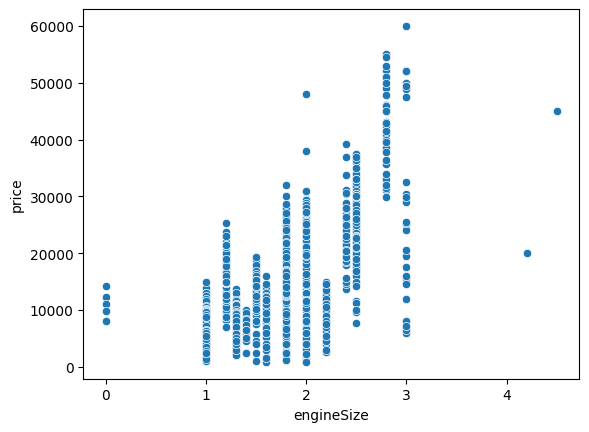

In [129]:
sns.scatterplot(df, x="engineSize", y="price")

### Outliers

<Axes: xlabel='price'>

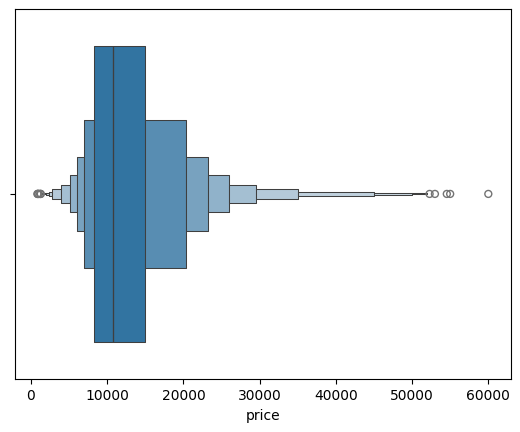

In [130]:
sns.boxenplot(df, x="price")

The query below shows the top 20 prices. As mentioned earlier in the project we used `describe()` method to examine the details of the dataframe and discovered that the mean (average) of the `price` column is `12522`.

In [131]:
df.sort_values("price", ascending=False).head(20)

,year,price,mileage,tax,mpg,engineSize
6711,2019,59995,9909,150,34.5,3.0
6670,2019,54991,1000,145,30.1,2.8
6695,2020,54550,4000,150,30.1,2.8
6688,2020,52990,1244,145,30.1,2.8
6672,2020,52291,3104,145,30.1,2.8
6704,2019,51995,1902,145,34.5,3.0
6703,2019,51995,250,145,34.5,3.0
6707,2019,51995,4153,145,34.5,3.0
6667,2019,50995,6254,145,30.1,2.8
6661,2020,50995,3390,145,30.1,2.8


To ensure our model is fed with clean data, we will proceed with 99% of our dataframe, excluding the outliers.

In [132]:
len(df) * 0.01

66.99

In [133]:
df_99 = df.sort_values("price", ascending=False).iloc[67:]

In [134]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000
mean,2016.742797,12529.799074,22889.588745,94.549933,63.078728,1.471996
std,2.205271,6358.562625,19109.288501,73.942649,15.861037,0.435624
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8266.500000,9488.500000,0.000000,55.400000,1.000000
50%,2017.000000,10798.000000,18571.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31059.500000,145.000000,70.600000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


Standard deviation and max values of `price` has noticeably decreased.

In [135]:
df_99.describe()

,year,price,mileage,tax,mpg,engineSize
count,6632.000000,6632.000000,6632.000000,6632.000000,6632.000000,6632.000000
mean,2016.721502,12225.876659,23045.107057,93.850271,63.347286,1.459153
std,2.203102,5575.613575,19119.879606,73.707082,15.682645,0.417395
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8242.250000,9650.000000,0.000000,55.400000,1.000000
50%,2017.000000,10750.000000,18704.000000,135.000000,62.800000,1.500000
75%,2018.000000,14895.500000,31182.250000,145.000000,70.600000,1.800000
max,2020.000000,32990.000000,174419.000000,565.000000,235.000000,4.200000


The figure below appears to be more useful for our analysis

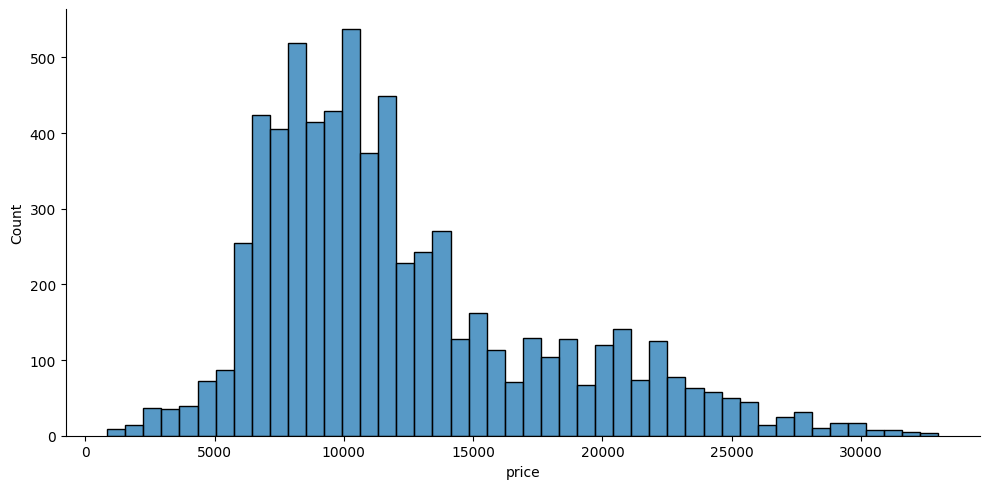

In [136]:
sns.displot(df_99, x="price", height=5, aspect=2)

### Mean Price Values by Year

In [137]:
df_99.groupby("year")["price"].mean()

year
1998    19990.000000
1999     1995.000000
2000     2695.000000
2001      899.000000
2002     1811.000000
2003     1984.166667
2004     3893.571429
2005     3054.416667
2006     3109.454545
2007     2797.500000
2008     3926.210526
2009     4160.413793
2010     5397.500000
2011     5341.425000
2012     6634.595238
2013     8413.438424
2014     8957.405714
2015     9836.541267
2016    11680.748231
2017    12115.670483
2018    12355.998026
2019    15915.367948
2020    20150.785714
Name: price, dtype: float64

Look at the `year` and its `price` value of the result of the query above. This is quite high, possibly because the model or models from 1998 are considered classics or are scarce on the market.

For this reason, we will remove this year.

In [138]:
df[df.year != 1998].groupby("year")["price"].mean()

year
1999     1995.000000
2000     2695.000000
2001      899.000000
2002     1811.000000
2003     1984.166667
2004     3893.571429
2005     3054.416667
2006     3109.454545
2007     2797.500000
2008     3926.210526
2009     4160.413793
2010     5397.500000
2011     5341.425000
2012     6634.595238
2013     8413.438424
2014     9060.062678
2015     9886.078544
2016    11702.282828
2017    12191.800000
2018    12384.738659
2019    16814.223715
2020    23033.236220
Name: price, dtype: float64

In [139]:
df = df_99

In [140]:
df = df[df.year != 1998]

### Splitting the Data into Train and Test

Now, we will split the data into train and test. Generally, the test size is set to 30%.

In [141]:
y = df["price"].values
x = df.drop("price", axis=1).values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=10)

The scaling process brings all features between 0 and 1, allowing the model to learn more effectively.

In [142]:
scaler = MinMaxScaler()

In [143]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

print(f"x_train: {x_train.shape} \nx_test: {x_test.shape}")

x_train: (4641, 5) 
x_test: (1990, 5)


### Model

Here, we are building a neural network model using the `Sequential`. It consists of four hidden layers with `12` neurons each, using the `ReLU` activation function. The output layer has a single neuron for regression purposes. The model is compiled with the `Adam` optimizer and `Mean Squared Error (MSE)` as the loss function.

In [144]:
model = Sequential()

model.add(Dense(12, activation="relu"))
model.add(Dense(12, activation="relu"))
model.add(Dense(12, activation="relu"))
model.add(Dense(12, activation="relu"))

model.add(Dense(1))

model.compile(optimizer = "adam", loss="mse")

In [145]:
model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=250, epochs=300)

Epoch 1/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 178794416.0000 - val_loss: 183021696.0000
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 179939056.0000 - val_loss: 183002656.0000
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 177560304.0000 - val_loss: 182970768.0000
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 173755152.0000 - val_loss: 182916848.0000
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 174711440.0000 - val_loss: 182825792.0000
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 182083360.0000 - val_loss: 182674016.0000
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 179487328.0000 - val_loss: 182425312.0000
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 178752208.0000 - val_loss: 182028368.0000
Epoch 9/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 179092944.0000 - val_loss: 181412864.0000
Epoch 10/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 179197392.0000 - val_loss: 1804

In [146]:
lossData = pd.DataFrame(model.history.history)
lossData.head()

,loss,val_loss
0,179424928.0,183021696.0
1,179410128.0,183002656.0
2,179385776.0,182970768.0
3,179345248.0,182916848.0
4,179277008.0,182825792.0


The figure of the `lossData` below looks ideal.

<Axes: >

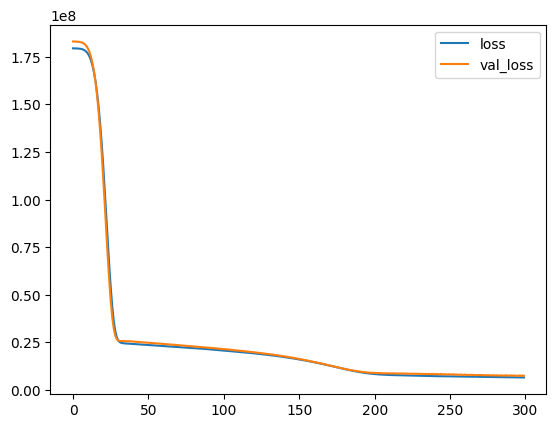

In [147]:
lossData.plot()

In [148]:
predictArray = model.predict(x_test)
predictArray

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[ 6841.2305],
       [10705.656 ],
       [ 8776.112 ],
       ...,
       [14923.632 ],
       [ 5362.462 ],
       [15888.493 ]], dtype=float32)

### Mean Absolute and Squared Errors

In [149]:
mean_absolute_error(y_test, predictArray)

1887.1688232421875

`Mean Absolute Error (MAE)` of 1887.17 compared to the average price of 12529.80 suggests that, on average, our model's predictions deviate from the actual values by about 15%. Given that the standard deviation is 6358.56, which indicates a wide spread of price values, our MAE seems relatively reasonable.

In [150]:
mean_squared_error(y_test, predictArray)

7501873.5

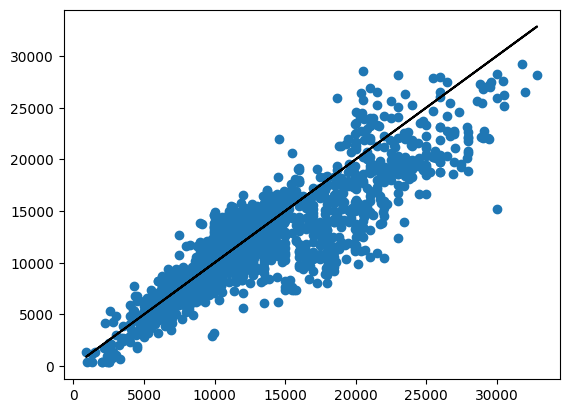

In [151]:
plt.scatter(y_test, predictArray)
plt.plot(y_test, y_test, color="black")

### Testing Model

Finally, we will test our model using a custom value from the dataframe.

The price value at the 2nd index is below:

In [156]:
df.iloc[2] # Price: 32498

year           2015.0
price         32498.0
mileage       16871.0
tax             325.0
mpg              34.9
engineSize        3.0
Name: 6652, dtype: float64

In [153]:
newCarSeries = df.drop("price", axis=1).iloc[2]
newCarSeries = scaler.transform(newCarSeries.values.reshape(-1, 5))

In [154]:
model.predict(newCarSeries)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[29299.047]], dtype=float32)

The actual price value at the 2nd index is 32498, our model predicted it as 29299. The model we created can, of course, be improved to return more accurate values.